# Question 2 [Neural Network’s Decision Boundary, 30 Marks]

## I. Load Task2B_train.csv and Task2B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

In [1]:
options(warn = -1) # set warning to be false.

# load libraries
library(ggplot2)
library(grid)
library(reshape2)

# load data
task3b.data.train <- read.csv('./Task2B_train.csv')
task3b.data.test <- read.csv('./Task2B_test.csv')

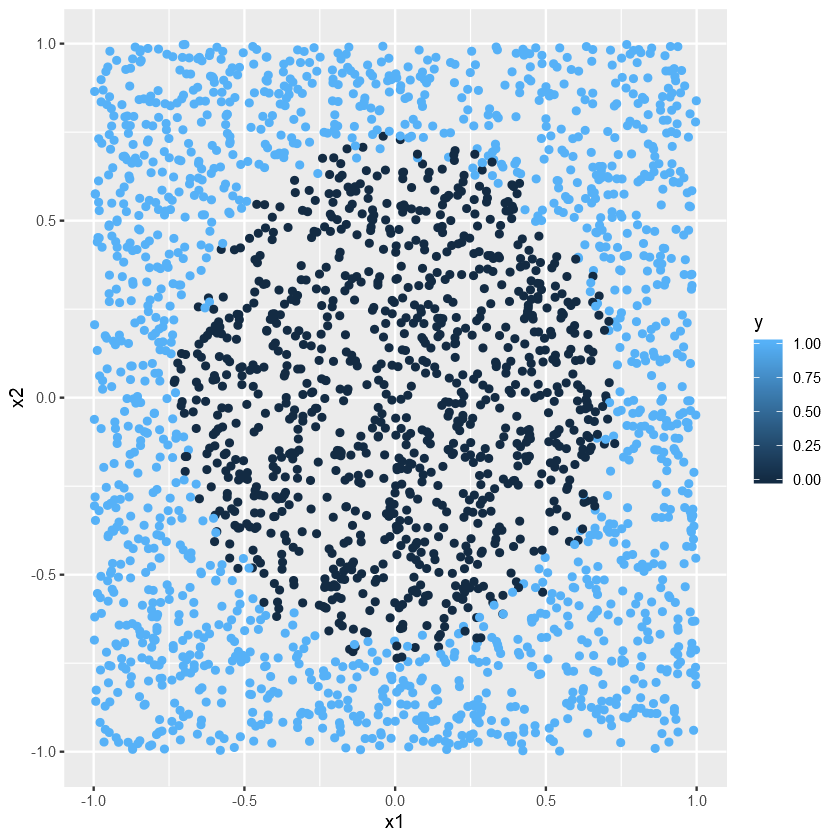

In [2]:
# plot the training data
ggplot(data= task3b.data.train, aes(x= x1, y = x2, color=y)) + geom_point()

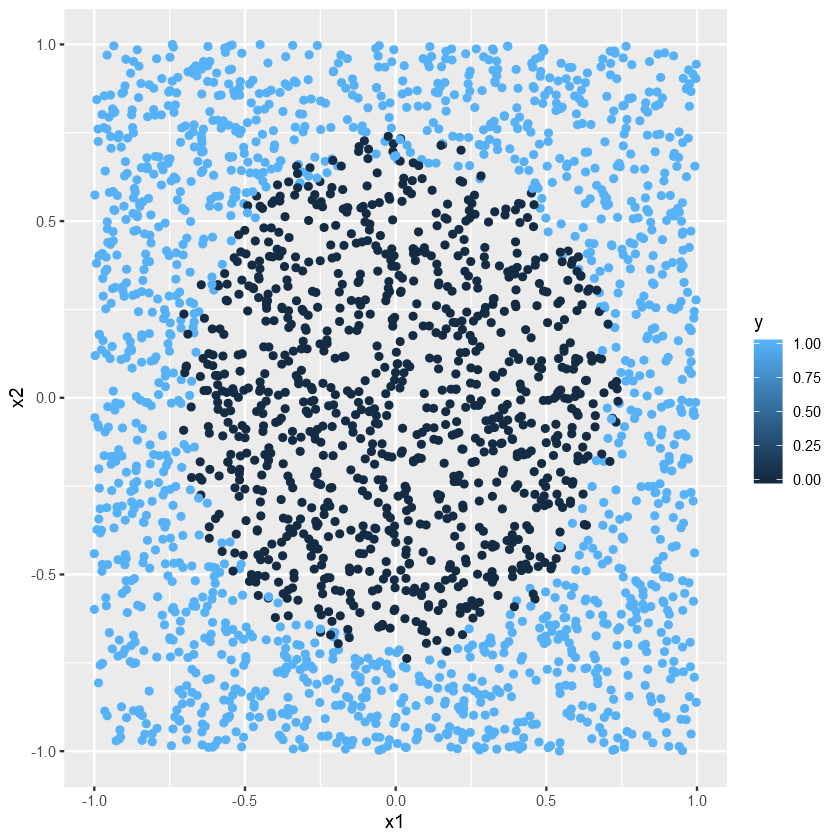

In [3]:
# plot the testing data
ggplot(data= task3b.data.test, aes(x= x1, y = x2, color=y)) + geom_point()

## II. Run the implementations of Perceptron given to you in Activity 3.1, calculate the test error, and plot the test data while the points are colored with their estimated class labels; attach the pdf to your report.

In [4]:
# refers to refers to assignment2 codebase A2Q2
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

In [5]:
## prediction
## predict the class of each point if it is greater than 0, it belongs to class 1, otherwise, class2.
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
## judge if the point is miss-classified
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
##  main function of perceptron classifier
##  Input: training data, training label
##  Output: model weights vector
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0
  
  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

In [6]:
# Training prcess
# Read the datasets
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries
list[X1,T1] <- read.data('./Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('./Task2B_test.csv') # read test data
T2[T2==0] <- -1  

# Build perceptron model
W<-perceptron.build(X1, T1, tau.max = 1000, plotting = FALSE)

In [7]:
# Testing process
# Test on testing data
Phi1 <- as.matrix(cbind(1,X2))
predict.result <- perceptron.predict(Phi1,W)
test.result <- as.matrix(cbind(X2,predict.result))
test.result <- as.data.frame(test.result)
names(test.result) <- c('x1','x2','y')

# Calculate test error
error1 <- error.rate(predict.result,T2)
error1

[1] 0.514

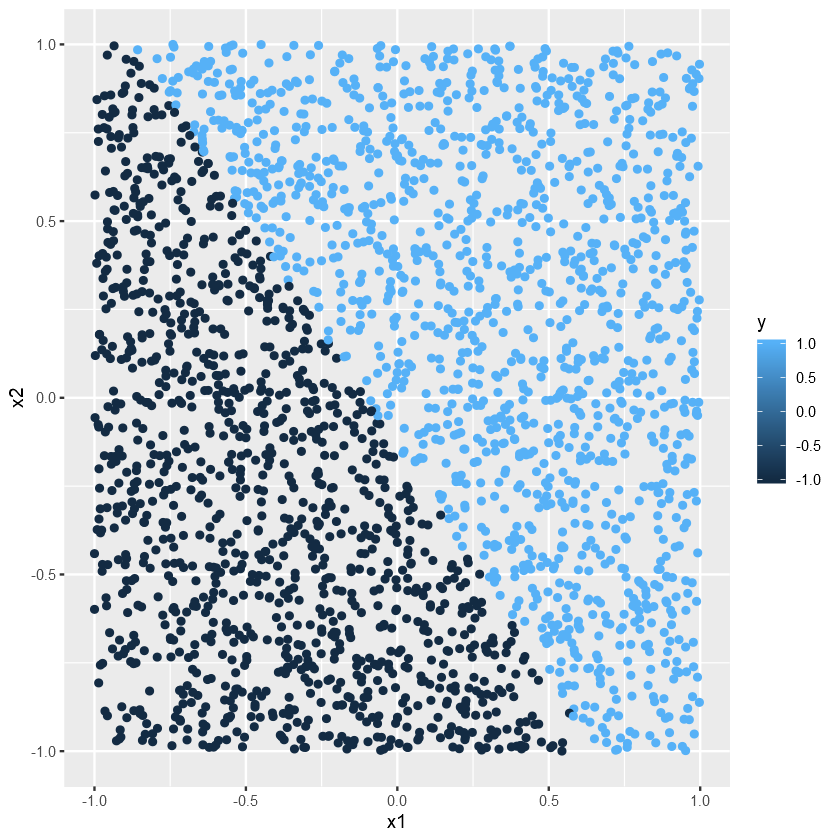

In [8]:
# Plot test result
ggplot(data=test.result, aes(x=x1,y=x2,color=y)) + geom_point()

## III. Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your report.


In [9]:
## the activation function 
h <- function(z, a=1) { 
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function 
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)
  
  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)
  
  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0
    
    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  #plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}

In [10]:
# Training precess
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# Create a dataframe to record training result
training.result <- data.frame(k=seq(2,100,2),W1=NA*50,W2=NA*50,b1=NA*50,b2=NA*50,error=NA*50)

for (k in seq(2,100, 2)) {
  
  # record model parameters  
  list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=1000, eta = 0.1, lambda = 0.01)
  
  #Record the test errors for plotting purposes (TO BE COMPLETE) 
  training.result[training.result$k==k,2][[1]] <- list(W1)
  training.result[training.result$k==k,3][[1]] <- list(W2)
  training.result[training.result$k==k,4][[1]] <- list(b1)
  training.result[training.result$k==k,5][[1]] <- list(b2)
  training.result[training.result$k==k,6] <- error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2) 
    
}
print('done')

[1] "done"


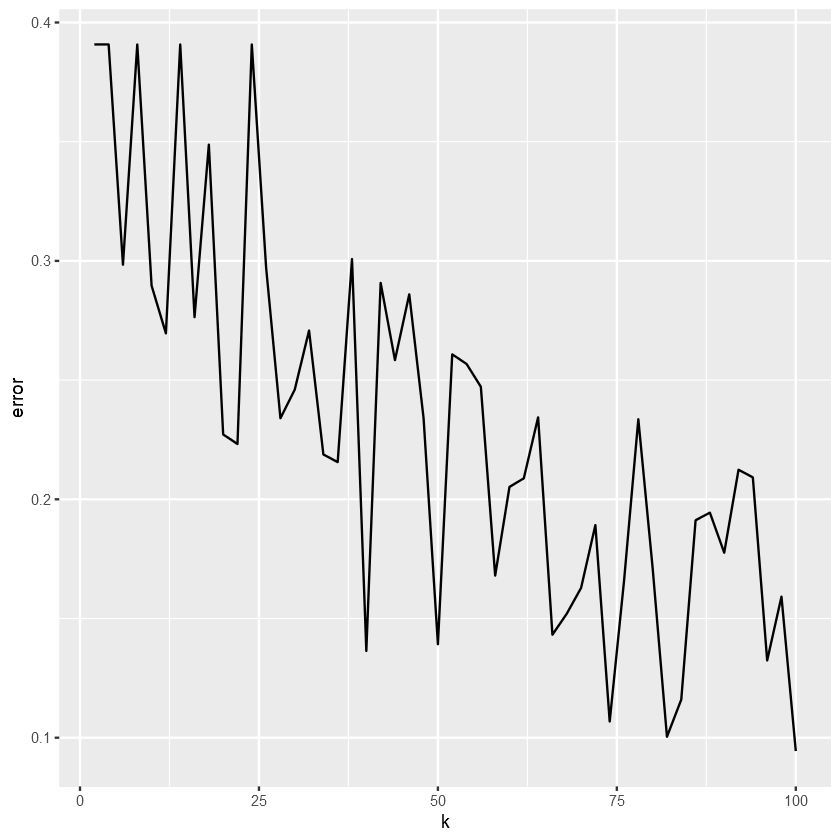

In [11]:
# Plot test error vs k
ggplot(data=training.result,aes(x=k,y=error))+geom_line()

In [12]:
# setup the best value to k
k.best <- 100

In [13]:
predict.label <- nn.predict(X2.t, training.result[training.result$k==k.best,'W1'][[1]], training.result[training.result$k==k.best,'W2'][[1]], training.result[training.result$k==k.best,'b1'][[1]], training.result[training.result$k==k.best,'b2'][[1]])  
predict.result <- as.matrix(cbind(X2,T2,t(predict.label)))
predict.result <- as.data.frame(predict.result,col.names = c('x1','x2','y','y1'))  
names(predict.result) <- c('x1','x2','y','y1')

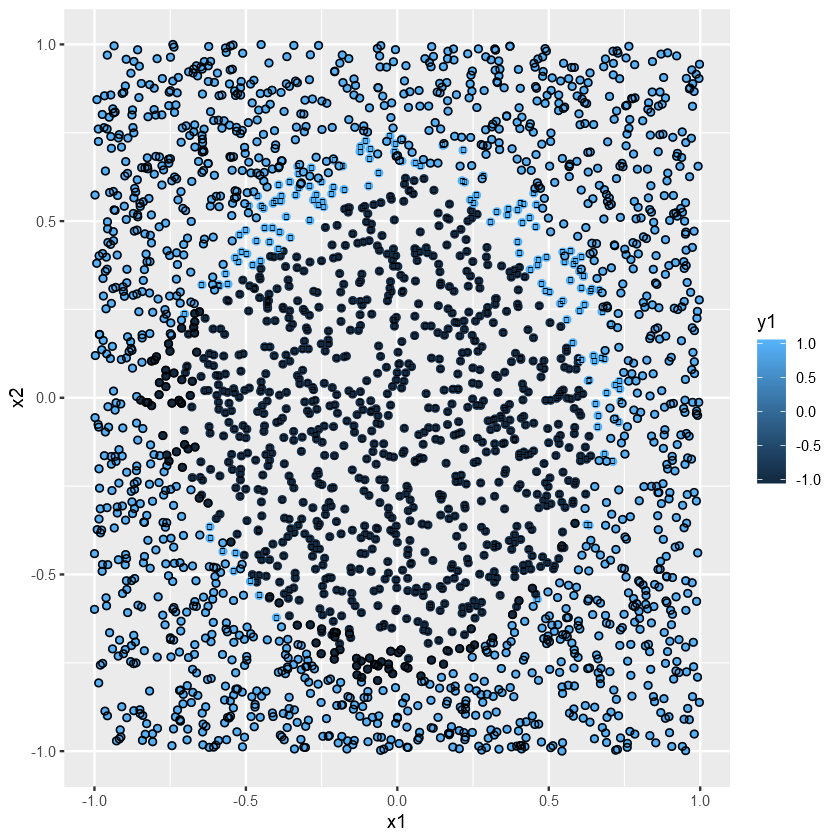

In [14]:
# The shape of data points represent to true label (with black circle and without black circle)
# The color of data points represent to predicted label
ggplot(data = predict.result,aes(x=x1,y=x2))+geom_point(aes(color=y1))+geom_point(aes(shape=y))+scale_shape_identity()

## IV. In a table, report the error rates obtained by the perceptron and all variants of NN. Then bold the best model (with minimum error). Save this table to report.

In [15]:
table.error <- data.frame(k = 2:51, type =rep('Neural Network',50),error = 0*50)
table.error <- rbind(data.frame(k=1,type='Perceptron',error=error1),table.error)
table.error[2:51,c('k','error')] <- training.result[,c('k','error')]

In [26]:
# install.packages('knitr', repos = "http://cran.us.r-project.org")
# install.packages('kableExtra', repos = "http://cran.us.r-project.org")
# install.packages('IRkernel', repos = 'http://irkernel.github.io/')

Installing package into 'C:/Users/Claude/Documents/R/win-library/3.5'
(as 'lib' is unspecified)


In [34]:
library(knitr)
library(kableExtra)
library(IRdisplay)
table.error %>% 
  kable("html") %>%
  kable_styling("striped", full_width = F) %>%
  row_spec(51, bold = T) %>%
  as.character() %>%
  display_html()

k,type,error
1,Perceptron,0.5140
2,Neural Network,0.3908
4,Neural Network,0.3908
6,Neural Network,0.2984
8,Neural Network,0.3908
10,Neural Network,0.2896
12,Neural Network,0.2696
14,Neural Network,0.3908
16,Neural Network,0.2764
18,Neural Network,0.3488


## V. In your report, explain the reason(s) responsible for such difference between perceptron and a 3-layer NN.

### See the report